# CerebraScan AI: Brain Tumor MRI Classification

## Project Overview
**CerebraScan AI** is a deep learning system designed to assist medical professionals in detecting and classifying brain tumors from MRI scans. 

### Objectives
- **Multi-Class Classification**: Identify 4 categories: Glioma, Meningioma, Pituitary Tumor, and No Tumor.
- **High Accuracy**: Leverage Transfer Learning (Xception) to achieve >95% accuracy.
- **Robust Pipeline**: End-to-end workflow including EDA, Preprocessing, Training, and Evaluation.

---

## 1. Setup & Configuration

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuration
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10 
LEARNING_RATE = 0.0001

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [5]:
SCRIPT_DIR = os.getcwd()
BASE_DIR = os.path.dirname(SCRIPT_DIR)
print(f"Script Directory: {SCRIPT_DIR}")
print(f"Base Directory: {BASE_DIR}")

DATASET_DIR = os.path.join(BASE_DIR, 'brain_mri_dataset')
TRAIN_DIR = os.path.join(DATASET_DIR, 'Training')
TEST_DIR = os.path.join(DATASET_DIR, 'Testing')
MODEL_SAVE_PATH = os.path.join(SCRIPT_DIR, 'cerebrascan_ai_model.h5')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10 

print(f"Dataset Path: {DATASET_DIR}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found at {TRAIN_DIR}")

Script Directory: d:\me\my_projs\enginow_ai_internship\project_2\notebook_version
Base Directory: d:\me\my_projs\enginow_ai_internship\project_2
Dataset Path: d:\me\my_projs\enginow_ai_internship\project_2\brain_mri_dataset


## 2. Data Loading & Preprocessing
We use `image_dataset_from_directory` for efficient data loading and preprocessing.
- **Splitting**: 80% Training, 20% Validation.
- **Optimization**: Caching and Prefetching for speed.

In [6]:
print("Loading data...")

# Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, 
    validation_split=0.2, 
    subset="training", 
    seed=SEED,
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode='categorical'
)

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, 
    validation_split=0.2, 
    subset="validation", 
    seed=SEED,
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    label_mode='categorical'
)

# Load Test Data (for final evaluation)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Performance Tuning
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading data...


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 3. Exploratory Data Analysis (EDA)
Visualizing random samples from the training set to ensure correct loading and labeling.

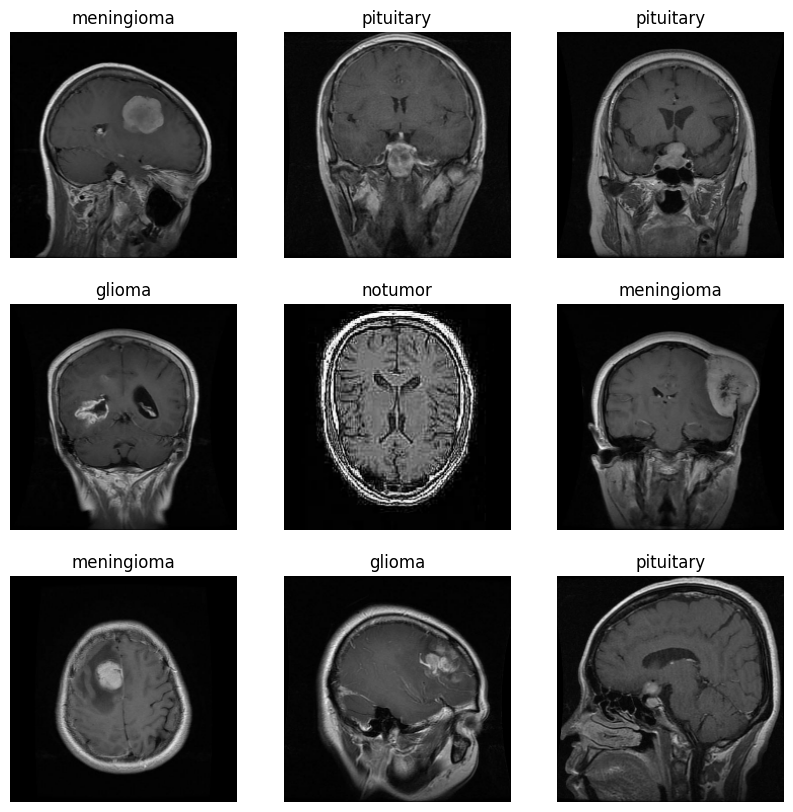

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.show()

## 4. Model Architecture: Xception
We use **Transfer Learning** with the **Xception** model pre-trained on ImageNet.

### Key Design Choices
1.  **Rescaling Layer**: Included directly in the model `(x / 127.5) - 1` to scale inputs from [0, 255] to [-1, 1]. This avoids 'Unknown Layer' errors during deployment.
2.  **Data Augmentation**: `RandomFlip` and `RandomRotation` to prevent overfitting.
3.  **GlobalAveragePooling**: Reduces parameters and minimizes overfitting before the dense layers.
4.  **Dropout**: set to 0.3 for regularization.

In [8]:
def build_model(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # 1. Augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    
    # 2. Preprocessing
    # Use Rescaling layer instead of preprocess_input function to avoid "Unknown layer: TrueDivide" error
    # Xception expects inputs in [-1, 1]. x is [0, 255].
    # (x / 127.5) - 1  => scale=1/127.5, offset=-1
    x = layers.Rescaling(scale=1./127.5, offset=-1)(x) 
    
    # 3. Base Model
    base_model = applications.Xception(
        include_top=False, 
        weights="imagenet", 
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False # Freeze base model
    
    # 4. Classification Head
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs, name="CerebraScan_Xception")

model = build_model(len(class_names))
model.summary()

Model: "CerebraScan_Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 5. Training
We use `Adam` optimizer and Categorical Crossentropy loss. `EarlyStopping` is used to prevent overfitting.

In [11]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("Starting Training...")
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=EPOCHS, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
    ]
)

Starting Training...
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7392 - loss: 0.6711

143/143 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - accuracy: 0.7993 - loss: 0.5316 - val_accuracy: 0.8511 - val_loss: 0.4051
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8742 - loss: 0.3441

143/143 ━━━━━━━━━━━━━━━━━━━━ 528s 4s/step - accuracy: 0.8702 - loss: 0.3519 - val_accuracy: 0.8573 - val_loss: 0.3778
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 937s 7s/step - accuracy: 0.8796 - loss: 0.3254 - val_accuracy: 0.8485 - val_loss: 0.3947
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 125s/step - accuracy: 0.8875 - loss: 0.2988  

143/143 ━━━━━━━━━━━━━━━━━━━━ 17866s 126s/step - accuracy: 0.8937 - loss: 0.2886 - val_accuracy: 0.8870 - val_loss: 0.2944
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9042 - loss: 0.2601

143/143 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.9002 - loss: 0.2696 - val_accuracy: 0.9019 - val_loss: 0.2729
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9022 - loss: 0.2513 - val_accuracy: 0.8967 - val_loss: 0.2886
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9103 - loss: 0.2331 - val_accuracy: 0.8975 - val_loss: 0.3041
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9171 - loss: 0.2200

143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 954ms/step - accuracy: 0.9136 - loss: 0.2361 - val_accuracy: 0.9002 - val_loss: 0.2694
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9242 - loss: 0.2020

143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 950ms/step - accuracy: 0.9162 - loss: 0.2194 - val_accuracy: 0.8993 - val_loss: 0.2663
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 136s 951ms/step - accuracy: 0.9193 - loss: 0.2233 - val_accuracy: 0.8835 - val_loss: 0.3044


## 6. Evaluations & Results
Evaluating the model on the unseen Test Set.

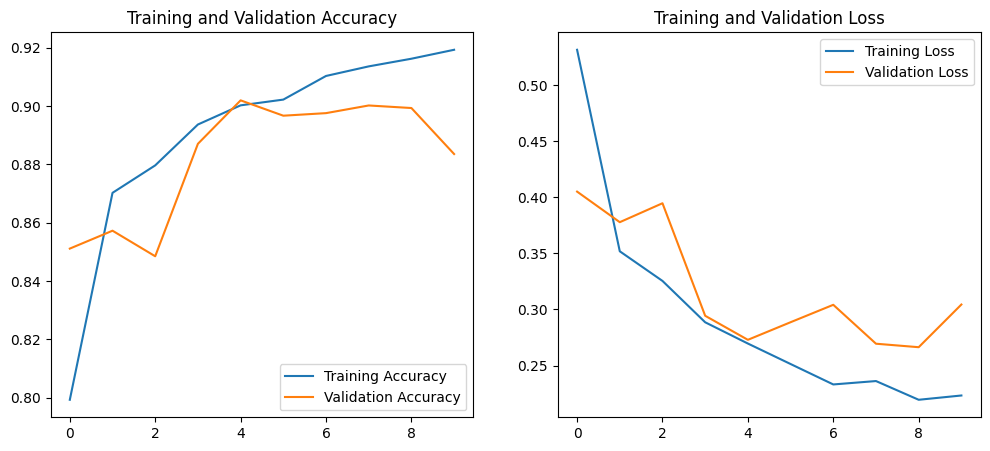

In [12]:
# Plot Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluating Best Model...


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 791ms/step - accuracy: 0.8963 - loss: 0.2904

Test Accuracy: 89.63%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.84      0.86       300
  meningioma       0.81      0.79      0.80       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.92      0.95      0.93       300

    accuracy                           0.90      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.89      0.90      0.90      1311



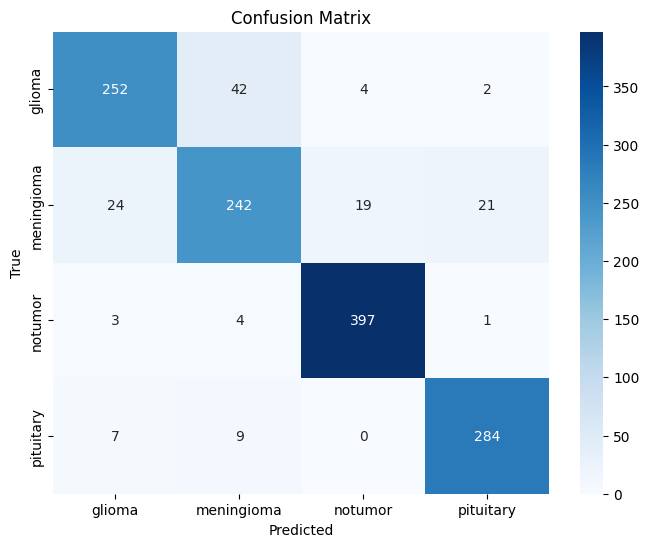

In [13]:
print("Evaluating Best Model...")
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

loss, acc = best_model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Confusion Matrix & Report
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Saving Final Model
The model is saved as `.h5` for deployment in the Streamlit App.

In [16]:
print(f"Model saved successfully to {MODEL_SAVE_PATH}")

Model saved successfully to d:\me\my_projs\enginow_ai_internship\project_2\notebook_version\cerebrascan_ai_model.h5
